# Validation Set 1 LTOO

In [1]:
import os
import time

import itertools
from collections import defaultdict


from openpyxl import load_workbook
import networkx as nx

##### PyBEL imports

In [2]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

##### PathMe import 

In [3]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

##### DiffuPath import 

In [16]:
import diffupath

from diffupath.constants import DATA_DIR, SOURCE_DIR
DATA_DIR = os.path.join('/Users/Projects/MultiPath/', 'results', 'data')
from diffupath.validation_datasets_parsers import parse_set1

from diffupath.pathme_importer import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap, show_venn_diagram


## 1. Load Data Set 1: Input Scores

In [17]:
dataset1_labels_by_omics = parse_set1(os.path.join(DATA_DIR, 'validation_datasets', 'set1.xlsx'))
dataset1_all_labels = get_labels_set_from_dict(dataset1_labels_by_omics)
print_dict_dimensions(dataset1_labels_by_omics, 'Dataset1 imported labels:')

Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [18]:
mirnas_dataset =  dataset1_labels_by_omics['micrornas']

## 2. Load Backrgound Network

### 2.1. Import PathMeUniverse graph

In [21]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(DATA_DIR, 'pickles', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

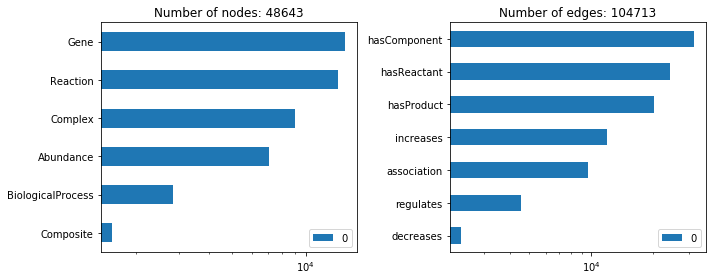

In [22]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Check and filter isolates / Unconnected nodes

In [23]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

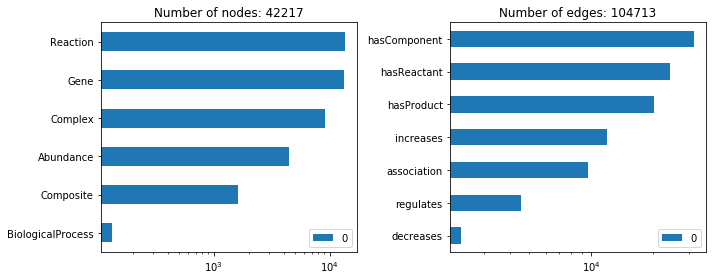

In [24]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.3. Get entity labels subsets by entity type (omic) and by database

#####  2.3.1. From PathMe package subsets

In [25]:
bg_labels_from_pathme_by_db_and_omic, bg_labels_from_pathme_by_omic_and_db = get_labels_by_db_and_omic_from_pathme(['reactome', 'kegg', 'wikipathways'])

print_dict_dimensions(bg_labels_from_pathme_by_db_and_omic, 'Entities in PathMe package :')


Total number of reactome: genes(8653), mirna(13), metabolites(2712), bps(2219),  
Total number of kegg: genes(7656), mirna(149), metabolites(4421), bps(418),  
Total number of wikipathways: genes(3361), mirna(91), metabolites(657), bps(135),  
Total: 30485 


In [26]:
bg_labels_from_pathme_by_omic = reduce_dict_dimension(bg_labels_from_pathme_by_omic_and_db)

#####  2.3.2.  From PathMeUniverse KEGG subgraph

In [13]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total number of reactome: gene_nodes(8615), mirna_nodes(13), metabolite_nodes(2684), bp_nodes(5),  
Total number of wikipathways: gene_nodes(2549), mirna_nodes(91), metabolite_nodes(618), bp_nodes(152),  
Total: 22750 


In [14]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.4. Get Background  Matrix Kernel

In [15]:
kernel_path = os.path.join(DATA_DIR, 'pickles', 'universe', 'regularized_kernel_pathme_universe.pickle')

##### Generate kernel OR load from pickle

DiffuPy to generate laplacian_kernel

In [16]:
#import diffupy
#from diffupy.kernels import regularised_laplacian_kernel

In [17]:
#background_mat = regularised_laplacian_kernel(pathme_universe_graph_no_flatten)
#to_pickle(regularised_laplacian_kernel, kernel_path)

Import kernel from pickle

In [18]:
background_mat = from_pickle(kernel_path)

## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [25]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [20]:
all_labels_mapping = get_mapping(dataset1_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (2673) 52.805215329909124%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [21]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset1_labels_by_omics, background_labels, 'entity type/omic', mirnas = mirnas_dataset)


Mapping by entity type/omic:
genes (2655) 53.73406193078324%
micrornas (19) 19.0%
metabolite (18) 85.71428571428571%
Total (2692) 53.18056104306598% 



In [22]:
micrornas_mapping = mapping_by_entity['micrornas'][0]

#### 3.2.2. Mapping by database

In [32]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset1_all_labels, 'database', mirnas = mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (1639) 32.378506519162386%
reactome (1274) 25.167917819043854%
wikipathways (807) 15.942315290399051%
Total (2423) 47.86645594626629% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [24]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset1_all_labels, relative_statistics = dataset1_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (1615) 32.68569115563651%
mirna_nodes (12) 12.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1639) 20.428767294029665% 

Mapping by Reactome:
gene_nodes (1259) 25.480671928759364%
mirna_nodes (3) 3.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1274) 11.257400371123088% 

Mapping by Wikipathways:
gene_nodes (775) 15.68508399109492%
mirna_nodes (13) 13.0%
metabolite_nodes (18) 85.71428571428571%
bp_nodes (1) 0%
Total (807) 23.66568914956012% 

Total (2423) 47.86645594626629% 



### 3.3. Mapping descriptive view

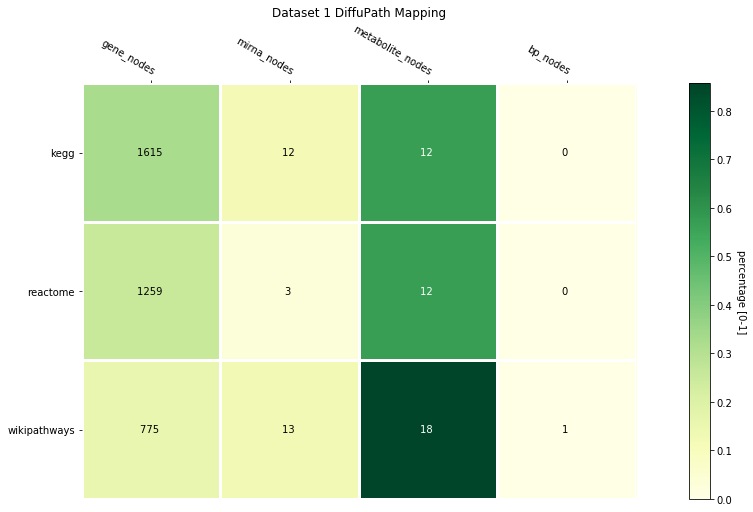

In [26]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)

show_heatmap(count, percentage, db_labels, entity_labels)


### 3.4. Overlap view

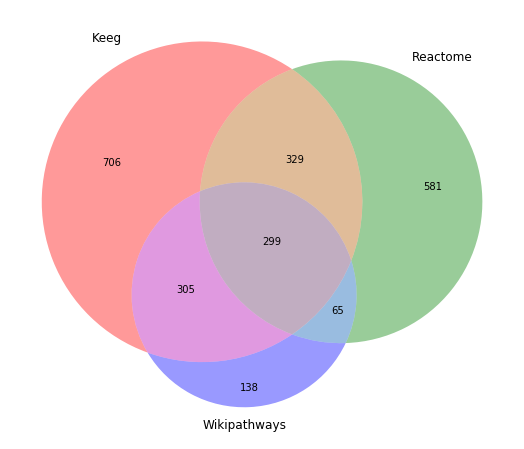

In [27]:
db_intersections = get_three_venn_intersections(mapping_by_db['kegg'][0], mapping_by_db['reactome'][0], mapping_by_db['wikipathways'][0])

show_venn_diagram(db_intersections)


### 3.5. Database disjoint

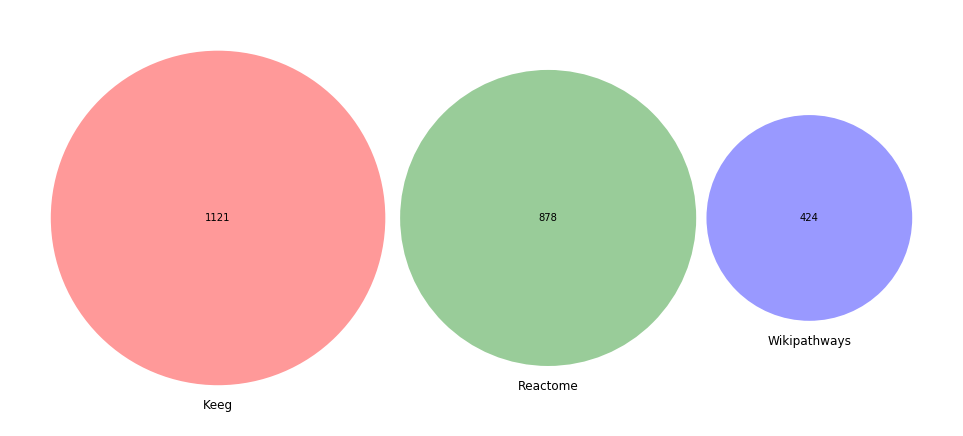

In [28]:
disjoint_db_mapping = random_disjoint_intersection_three_subsets(mapping_by_db)

show_venn_diagram(get_three_venn_intersections(*list(disjoint_db_mapping.values())))

## 4. Cross-validation

In [1]:
from diffupath.views import box_plot_from_dict
from diffupath.cross_validation import cross_validation_one_x_in

### 4.1. Random Scheme

#### 4.1.1.  By method

In [28]:
auroc_metrics_by_method, auprc_metrics_by_method = cross_validation_by_method(all_labels_mapping, pathme_universe_graph_no_flatten, background_mat, k=10)


100%|██████████| 10/10 [01:11<00:00,  7.04s/it]


In [ ]:
auroc_metrics_by_method, auprc_metrics_by_method = cross_validation_one_x_in(mapping_by_entity, background_mat)

 67%|██████▋   | 2/3 [32:39<16:26, 986.60s/it]

In [ ]:
auroc_metrics_by_method

In [ ]:
auprc_metrics_by_method

In [30]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [31]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

#### 5.1.2.  By entity

In [32]:
auroc_metrics_by_entity, auprc_metrics_by_entity = cross_validation_by_subset_same_diff_input(mapping_by_entity, background_mat, k = 10)


100%|██████████| 10/10 [00:44<00:00,  4.38s/it]


In [33]:
box_plot_from_dict(auroc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUROC')


/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [34]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')

### 5.2. Leave Two Omics Out (LTOO)

In [31]:
mapping_by_db

{'kegg': ({'bmf',
   'jun',
   'cers4',
   'pvr',
   'nfkbiz',
   'uxs1',
   'pdgfa',
   'nfya',
   'nceh1',
   'ccng2',
   'msi2',
   'dag1',
   'gpx7',
   'mir193b',
   'ldhd',
   'ndufa9',
   'f11r',
   'pgm2l1',
   'trpc1',
   'gyg2',
   'fxr2',
   'ppt1',
   'aldh1b1',
   'gadd45b',
   'osmr',
   'tspo',
   'znf684',
   'mica',
   'slc7a5',
   'daam1',
   'alg2',
   'znf224',
   'pcf11',
   'kiss1r',
   'rchy1',
   'adp',
   'ndufb1',
   'lrp1',
   'flot1',
   'zfp36',
   'myl6',
   'mlxipl',
   'sugt1',
   'lars2',
   'fhl2',
   'taldo1',
   'krt23',
   'mlx',
   'trpv2',
   'plcd3',
   'foxa3',
   'znf34',
   'nfe2l2',
   'apoh',
   'amy2b',
   'cyp2u1',
   'il4r',
   'znf823',
   'lama5',
   'akr1c3',
   'socs2',
   'prnp',
   'tubb2b',
   'hmgcs1',
   'uckl1',
   'espl1',
   'lipc',
   'mdm4',
   'tfdp1',
   'cebpa',
   'znf383',
   'shmt1',
   'xiap',
   'capn2',
   'gmppb',
   'tff1',
   'ephb4',
   'csnk2a2',
   'rapgef6',
   'asgr1',
   'rfng',
   'mmachc',
   'nsfl1c',
  

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db,
                                                                              disjoint = True,
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Leave Two DB Out Validation', 'DB', 'AUROC')